In [1]:
import unicodedata
import pandas as pd
import numpy as np
from faker import Faker
import random
import itertools

random.seed(10)

fake = Faker()

N_OWNER = 2500
N_EMPLOYEE = 60
N_COMPANY = N_OWNER * int(np.random.ranf() + 1)


def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    only_ascii = nfkd_form.encode('ASCII', 'ignore')
    return only_ascii.decode()

# 1. Industry table
industry_df = pd.DataFrame({
    'industry_name': ['medical supplies', 'logistics', 'construction']
})

def generate_random_date():
    # Generate a random year between 2012 and 2020
    year = np.random.randint(2012, 2021)
    # Generate a random month between 1 and 12
    month = np.random.randint(1, 13)
    # Generate a random day between 1 and 28
    day = np.random.randint(1, 29)
    # Format the date as a string
    random_date = f"{year:04d}-{month:02d}-{day:02d}"
    return random_date

# 2. Owner table
def generate_vietnamese_name():
    with open("last_name.txt", "r") as f:
        last_names = [i.strip() for i in (f.readlines())]
    with open("middle_name.txt", "r") as f:
        middle_names = [i.strip() for i in (f.readlines())]
    with open("first_name.txt", "r") as f:
        first_names = [i.strip() for i in (f.readlines())]
    return f"{random.choice(last_names)} {random.choice(middle_names)} {random.choice(first_names)}"

owner_df = pd.DataFrame({
    'owner_cmnd': [f"0300{fake.unique.random_number(digits=8, fix_len=True)}" for _ in range(N_OWNER)],
    'owner_name': [generate_vietnamese_name() for _ in range(N_OWNER)],
    'owner_sdt': [f"+84{fake.unique.random_number(digits=9, fix_len=True)}" for _ in range(N_OWNER)]
})

owner_df['owner_email'] = owner_df['owner_name'].apply(remove_accents).str.replace(' ', '').str.lower() + owner_df['owner_cmnd'] + '@gmail.com'


# 3. Employee table
employee_codes = [f"emp-{i}" for i in range(N_EMPLOYEE)]
employee_names = [fake.unique.first_name() for _ in range(N_EMPLOYEE)]
# areas = ['Hà Nội', 'Hải Phòng', 'Hồ Chí Minh', 'Quy Nhơn', 'Đà Nẵng', 'Khánh Hòa', 'Kiên Giang', 'Cần Thơ', 'Bình Thuận', 'Nghệ An', 'Hà Tĩnh', "Quảng Ninh", "Điện Biên", "Cao Bắng", "Thanh Hoá", "Ninh Thuận"]
areas = pd.read_csv("provinces.txt", header=None)[0]

In [2]:
employee_df = pd.DataFrame({
    'empl_persnbr': random.sample(employee_codes, N_EMPLOYEE),
    'empl_name': employee_names,
    'area': [random.choice(areas) for _ in range(N_EMPLOYEE)],
    'title': [random.choice(['title1', 'title2', 'title3']) for _ in range(N_EMPLOYEE)]
})

employee_df['branch'] = employee_df['area'] + '_' + pd.Series(np.random.randint(1,4, N_EMPLOYEE)).astype(str)


In [3]:
# 4. Company table
def generate_org_name():
    letters = ''.join(random.choices('ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789', k=5))
    suffix = random.choice(['JSC', 'LTD', 'CORP', 'GROUP', 'COMP', 'AND PARTNERS', 'ORG', 'HANOI', 'HCM'])
    scope = random.choice(['International', 'National', 'Global', 'Universal', 'Continental', "And Partners", "FAMILY"])
    return f"{letters} {suffix} {scope}"


company_df = pd.DataFrame({
    'tax_id': [f"{fake.unique.random_number(digits=10, fix_len=True)}" for _ in range(N_COMPANY)],
    'owner_cmnd': np.random.choice(owner_df['owner_cmnd'], N_COMPANY),
    'org_type': ["KHMOI" if random.random() <= .8 else "KHHH" for _ in range(N_COMPANY)],
    'nganh_trong_tam': np.random.choice(industry_df['industry_name'], N_COMPANY),
    'mnsegmtcd': np.random.choice(['SME', 'MMLC'], N_COMPANY),
    'post_tel': [f"+8420{fake.unique.random_number(digits=8, fix_len=True)}" for _ in range(N_COMPANY)],
    'ma_pers_nv': np.random.choice(employee_df['empl_persnbr'], N_COMPANY),
    'addrname': [random.choice(areas) for _ in range(N_COMPANY)],
    'gpkdngaycap': [generate_random_date() for _ in range(N_COMPANY)],
    "tpktdesc": [random.choice(["Nhà nước", "Tập thể", "Tư nhân", "Có vốn đầu tư nước ngoài"]) for _ in range(N_COMPANY)]
})
company_df['orgnbr'] = 'dn_' + company_df['tax_id']
company_df['org_name'] = [generate_org_name() for _ in range(N_COMPANY)]
company_df['post_mail'] = company_df['org_name'].str.lower().str.replace(' ', '') + [random.choice(['@gmail.com', '@yahoo.com']) for _ in range(N_COMPANY)]
company_df['website'] = company_df['org_name'].str.lower().str.replace(' ', '') + [random.choice(['.com', '.net', '.org', '.com.vn', '.io', '.uk']) for _ in range(N_COMPANY)]
company_df['start_date'] = company_df['gpkdngaycap']
company_df['approach_status'] = company_df['org_type'].apply(lambda x: '-' if x=='KHHH' else np.random.choice(['fresh',
                                                                                                               'scouted',
                                                                                                               'scheduled',
                                                                                                               'success',
                                                                                                               'failure',
                                                                                                               ],
                                                                                                              p=[.6,.2,.05, .05, .1]))

company_df['priority'] = company_df['org_type'].apply(lambda x: 3 if x=='KHHH' else  (1 if random.random() <=.7 else 2))
company_df['owner_cmnd'] = company_df.apply(lambda x: np.nan if x['priority']==2 else x['owner_cmnd'], axis=1)

In [4]:
import string

def generate_company_data(N):
    data = {
        "TOTAL_BALAMT": np.random.randint(1_000_000_000, 10_000_000_000, N).tolist(),
        "TOTAL_BALANCE": np.random.randint(1_000_000_000, 10_000_000_000, N).tolist(),
        "TONGTAISAN_2021": np.random.randint(10_000_000_000, 100_000_000_000, N).tolist(),
        "TONGTAISAN_2022": [],  # Will be the same as TONGTAISAN_2021
        "TAISAN_NGANHAN_2021": np.random.randint(1_000_000_000, 50_000_000_000, N).tolist(),
        "TAISAN_NGANHAN_2022": [],  # Will be the same as TAISAN_NGANHAN_2021
        "PHAITHU_2021": np.random.randint(1_000_000_000, 20_000_000_000, N).tolist(),
        "PHAITHU_2022": [],  # Will be the same as PHAITHU_2021
        "TAISAN_DAIHAN_2021": np.random.randint(1_000_000_000, 50_000_000_000, N).tolist(),
        "TAISAN_DAIHAN_2022": [],  # Will be the same as TAISAN_DAIHAN_2021
        "NO_DAIHAN_2021": np.random.randint(1_000_000_000, 20_000_000_000, N).tolist(),
        "NO_DAIHAN_2022": [],  # Will be the same as NO_DAIHAN_2021
        "NO_NGANHAN_2021": np.random.randint(1_000_000_000, 20_000_000_000, N).tolist(),
        "NO_NGANHAN_2022": [],  # Will be the same as NO_NGANHAN_2021
        "VONCHUSOHUU_2021": np.random.randint(1_000_000_000, 20_000_000_000, N).tolist(),
        "VONCHUSOHUU_2022": [],  # Will be the same as VONCHUSOHUU_2021
        "HANGTONKHO_2021": np.random.randint(1_000_000, 50_000_000, N).tolist(),
        "HANGTONKHO_2022": [],  # Will be the same as HANGTONKHO_2021
        "VAY_TCTD_KHAC": [random.choice(['Y', 'N']) for _ in range(N)],
        "CO_HD_XNK": [random.choice(['Y', 'N']) for _ in range(N)],
        "MAT_CAN_DOI_VON_2021": [random.choice(['Y', 'N']) for _ in range(N)],
        "MAT_CAN_DOI_VON_2022": [],  # Will be the same as MAT_CAN_DOI_VON_2021
        "TY_SO_THANH_TOAN_2021": np.random.uniform(0.5, 2.0, N).tolist(),
        "TY_SO_THANH_TOAN_2022": [],  # Will be the same as TY_SO_THANH_TOAN_2021
        "DOANH_THU_2021": np.random.randint(1_000_000_000, 50_000_000_000, N).tolist(),
        "DOANH_THU_2022": [],  # Will be the same as DOANH_THU_2021
        "LOI_NHUAN_TRUOC_THUE_2021": np.random.randint(100_000_000, 5_000_000_000, N).tolist(),
        "LOI_NHUAN_TRUOC_THUE_2022": [],  # Will be the same as LOI_NHUAN_TRUOC_THUE_2021
        "LOI_NHUAN_SAU_THUE_2021": np.random.randint(50_000_000, 4_000_000_000, N).tolist(),
        "LOI_NHUAN_SAU_THUE_2022": []  # Will be the same as LOI_NHUAN_SAU_THUE_2021
    }

    # Set values for 2022 to be the same as 2021
    for key in ["TONGTAISAN_2022", "TAISAN_NGANHAN_2022", "PHAITHU_2022", "TAISAN_DAIHAN_2022", "NO_DAIHAN_2022",
                "NO_NGANHAN_2022", "VONCHUSOHUU_2022", "HANGTONKHO_2022", "MAT_CAN_DOI_VON_2022",
                "TY_SO_THANH_TOAN_2022", "DOANH_THU_2022", "LOI_NHUAN_TRUOC_THUE_2022", "LOI_NHUAN_SAU_THUE_2022"]:
        data[key] = data[key[:-5] + "_2021"]

    return data

company_df_numeric = pd.DataFrame(generate_company_data(N_COMPANY))
company_df = pd.concat([company_df, company_df_numeric], axis=1)

In [5]:
# 5. Ledger table
num_ledger_rows = int(N_COMPANY * np.random.uniform(1.4, 1.8))
tax_ids = company_df['tax_id'].tolist()
ledger_pairs = list(itertools.permutations(tax_ids, 2))
random.shuffle(ledger_pairs)
ledger_pairs = ledger_pairs[:num_ledger_rows]

ledger_df = pd.DataFrame({
    'provider_tax_id': [pair[0] for pair in ledger_pairs],
    'customer_tax_id': [pair[1] for pair in ledger_pairs],
    'vat_number': np.random.randint(1, 11, num_ledger_rows),
    'total_vat_amount': np.random.randint(5, 5001, num_ledger_rows) * 1000000
})

# 6. Bank table
bank_df = pd.read_csv("./bank_name.txt")
bank_df['bank_name'] = bank_df['shortname']
bank_df = bank_df[['bank_name']]

In [6]:
# 7. CompBankBalance table
comp_bank_balance_data = []
for tax_id in company_df['tax_id']:
    num_accounts = random.randint(1, 3)
    banks = random.sample(bank_df['bank_name'].tolist(), num_accounts)
    for bank in banks:
        comp_bank_balance_data.append({
            'tax_id': tax_id,
            'bank_name': bank,
            'balance': int(np.random.uniform(-5, 15) * 1000000000)
        })

comp_bank_balance_df = pd.DataFrame(comp_bank_balance_data)

In [7]:
comp_bank_balance_df_total = dict(comp_bank_balance_df.groupby('tax_id')['balance'].sum())

<Axes: >

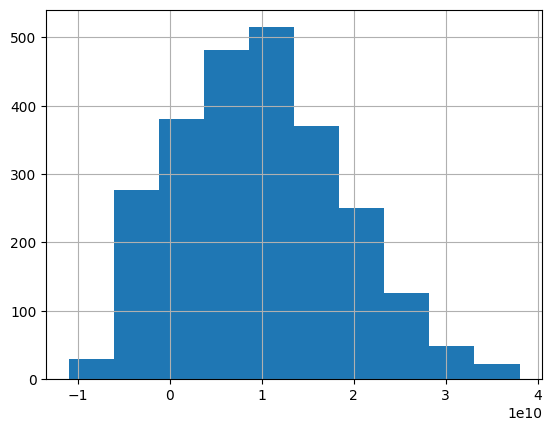

In [8]:
pd.Series(comp_bank_balance_df_total.values()).hist()

In [9]:
company_df['tong_du_no_tctd'] = company_df['tax_id'].apply(lambda x: comp_bank_balance_df_total[x])

In [10]:
# Print sample rows from each table
print("Industry Table:")
print(industry_df)

print("\nOwner Table (first 5 rows):")
print(owner_df.head())

print("\nEmployee Table (first 5 rows):")
print(employee_df.head())

print("\nCompany Table (first 5 rows):")
print(company_df.head())

print("\nLedger Table (first 5 rows):")
print(ledger_df.head())

print("\nBank Table:")
print(bank_df)

print("\nCompBankBalance Table (first 5 rows):")
print(comp_bank_balance_df.head())

# Optionally, save to CSV files
industry_df.to_csv("industry.csv", index=False)
owner_df.to_csv("owner.csv", index=False)
employee_df.to_csv("employee.csv", index=False)
company_df.to_csv("company.csv", index=False)
ledger_df.to_csv("ledger.csv", index=False)
bank_df.to_csv("bank.csv", index=False)
comp_bank_balance_df.to_csv("comp_bank_balance.csv", index=False)

Industry Table:
      industry_name
0  medical supplies
1         logistics
2      construction

Owner Table (first 5 rows):
     owner_cmnd      owner_name     owner_sdt  \
0  030030002646    Đặng Thị Huy  +84276460191   
1  030069671486      Vũ Anh Anh  +84940856172   
2  030059740689  Phạm Kim Thanh  +84679600097   
3  030082937849    Vũ Tuấn Hạnh  +84200558688   
4  030063557540   Bùi Gia Cường  +84232305928   

                          owner_email  
0     angthihuy030030002646@gmail.com  
1      vuanhanh030069671486@gmail.com  
2  phamkimthanh030059740689@gmail.com  
3    vutuanhanh030082937849@gmail.com  
4   buigiacuong030063557540@gmail.com  

Employee Table (first 5 rows):
  empl_persnbr empl_name         area   title         branch
0       emp-22   Anthony  Thái Nguyên  title1  Thái Nguyên_3
1       emp-54      Ryan      Hà Tĩnh  title1      Hà Tĩnh_1
2        emp-4    Steven       Hà Nội  title2       Hà Nội_1
3       emp-48     Brian   Bình Phước  title3   Bình Phước_1
4  

In [11]:
unique_check = [owner_df['owner_cmnd'],
                owner_df['owner_sdt'],
                employee_df['empl_persnbr'],
                company_df['tax_id'],
                company_df['org_name'],
                comp_bank_balance_df[['tax_id', 'bank_name']],
                ledger_df[['provider_tax_id', 'customer_tax_id']]
               ]
for f in unique_check:
    assert max(f.value_counts()) == 1


In [12]:
f

provider_tax_id customer_tax_id
0         2501121117      2329033582
1         8504901545      8240753978
2         6505005896      4964191377
3         6297587346      3995231071
4         2771976966      5358816410
...              ...             ...
4339      4130017505      4857436304
4340      7841215783      9442616091
4341      9074492548      4227725113
4342      5784403092      8616879459
4343      2193998000      3476614206

[4344 rows x 2 columns]

In [13]:

assert not (set(comp_bank_balance_df['tax_id']) - set(company_df['tax_id']))
assert not (set(company_df['owner_cmnd'].dropna()) - set(owner_df['owner_cmnd']))
assert not (set(company_df['ma_pers_nv']) - set(employee_df['empl_persnbr']))
assert not (set(company_df['nganh_trong_tam']) - set(industry_df['industry_name']))
assert not (set(ledger_df['provider_tax_id']) - set(company_df['tax_id']))
assert not (set(ledger_df['customer_tax_id']) - set(company_df['tax_id']))


In [14]:
N_NEWS = N_COMPANY * 3
comp_news = pd.DataFrame(
{
    "tax_id": np.random.choice(company_df['tax_id'], N_NEWS),
    "news":[fake.sentence(nb_words=5, variable_nb_words=False) for _ in range(N_NEWS)],
    "news_cls": np.random.choice(["good", "bad", "neutral"], N_NEWS),
    "news_date": [generate_random_date() for _ in range (N_NEWS)]
})


comp_news = comp_news.reset_index()
comp_news['stt'] = comp_news['index']
del(comp_news['index'])
comp_news[['stt', 'tax_id', 'news', 'news_cls', 'news_date']].to_csv("comp_news.csv", index=False)

In [15]:
company_df['approach_status'].value_counts()

approach_status
fresh        1193
-             506
scouted       394
failure       198
scheduled     109
success       100
Name: count, dtype: int64

# Meeting management

(`approach_status` >= scheduled)

Bảng kết quả tiếp cận

```
session_id,
empl
taxid
date
method
product
note
status
```


In [16]:
company_df['approach_status'].value_counts()

approach_status
fresh        1193
-             506
scouted       394
failure       198
scheduled     109
success       100
Name: count, dtype: int64

In [17]:
import uuid

def generate_meet_date():
    # Generate a random year between 2012 and 2020
    year = np.random.choice([2023, 2024])
    # Generate a random month between 1 and 12
    month = np.random.randint(1, 6)
    # Generate a random day between 1 and 28
    day = np.random.randint(1, 29)
    # Format the date as a string
    random_date = f"{year:04d}-{month:02d}-{day:02d}"
    return random_date


meeting_df = company_df[company_df["approach_status"].isin(['failure', 'success', 'scheduled'])][['tax_id', 'ma_pers_nv', 'approach_status']]
meeting_df['session_id'] = [uuid.uuid1().hex for _ in range(len(meeting_df))]
meeting_df['method'] = [random.choice(['gọi điện', 'hẹn gặp', 'gửi email']) for _ in range(len(meeting_df))]
meeting_df['product'] = "empty"
meeting_df['session_note'] = "empty"
meeting_df['session_date'] = [generate_meet_date() for _ in range(len(meeting_df))]

In [18]:
meeting_df = meeting_df[['session_id', "tax_id", "ma_pers_nv", "approach_status", "method", "product", "session_date", "session_note"]]

In [19]:
meeting_df.to_csv("sales_session.csv", index=False)

In [20]:
meeting_df['session_id'].str.len()

4       32
14      32
18      32
30      32
31      32
        ..
2444    32
2445    32
2457    32
2462    32
2470    32
Name: session_id, Length: 407, dtype: int64

In [21]:
def simulate_crawl_6161():
    return {
        "Mã số thuế": f"{fake.unique.random_number(digits=10, fix_len=True)}",
        "Số điện thoại": f"+84{fake.unique.random_number(digits=9, fix_len=True)}",
        "Ngày thành lập": generate_random_date(),
        "Đại diện": generate_vietnamese_name(),
        "Ngành nghề": np.random.choice(industry_df['industry_name']),
        "website": "abc.xyz.com"
    }
    

In [22]:
simulate_crawl_6161()

{'Mã số thuế': '4764977535',
 'Số điện thoại': '+84438112037',
 'Ngày thành lập': '2015-07-05',
 'Đại diện': 'Huỳnh Phước Phúc',
 'Ngành nghề': 'logistics',
 'website': 'abc.xyz.com'}